In [53]:
import math
import random
import minigrid
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from array2gif import write_gif
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from collections import namedtuple, deque

import gym_examples

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [54]:
class MinigridFeaturesExtractor(nn.Module):
    def __init__(self, observation_space: gym.Space, features_dim: int = 128, normalized_image: bool = False, concat=1) -> None:
        # TODO: normalize
        super().__init__()
        # super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[-1]*concat
        self.features_dim = features_dim
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 2, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(2, 4, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(4, 8, (3, 3)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()).unsqueeze(0).permute(0, 3, 1, 2).repeat(1, concat, 1, 1).float()).shape[1]  # [1,7,7,3]


        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [55]:
class Head(nn.Module):
    def __init__(self, input_dim, output_dim, if_prob=False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Sequential(nn.Linear(self.input_dim, self.input_dim), nn.ReLU(
        ), nn.Linear(self.input_dim, self.output_dim))
        self.if_prob = if_prob

    def forward(self, x, extra_x=None):
        # TODO: Relu
        # print("prev_x: ", x.size())
        if extra_x is not None:
            # TODO: change to one-hot encoding and may add Norm2d
            x = torch.cat((x, extra_x), dim=1)
            # print("extra_x: ", extra_x.size())
            # print("post_x: ", x.size())
        x = self.linear(x)
        if self.if_prob:
            return nn.functional.softmax(x, dim=1)
        else:
            return x

In [56]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'skill', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [67]:
num_skills = 4
skill_eps_len = 25  # 90 10
skill_eps_count = 10
num_episodes = 1000  # 600
discount = 0.9
final_step_discount = 0.99
lr_pred = 1e-4
lr_reg = 1e-4
lr_policy = 1e-4
lr_extractor = 1e-4
BATCH_SIZE = 64  # 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
features_dim = 64  # 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seaquest gpu out of memory
env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.AgentLocation(env)
# env = gym.make("MiniGrid-FourRooms-v0", render_mode="rgb_array")
# env = FullyObsWrapper(env)
# env = ImgObsWrapper(env)
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

# predictor_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=2)
# regularizer_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=1)
# policy_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=1)
# target_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=1)

feature_extractor = MinigridFeaturesExtractor(
    env.observation_space, features_dim=features_dim, concat=1).to(device)

predictor_net = Head(features_dim*2, num_skills, if_prob=True).to(device)
regularizer_net = Head(features_dim, num_skills, if_prob=True).to(device)
prev_predictor_net = Head(features_dim*2, num_skills, if_prob=True).to(device)
prev_regularizer_net = Head(features_dim, num_skills, if_prob=True).to(device)

policy_net = Head(features_dim+1, n_actions).to(device)
target_net = Head(features_dim+1, n_actions).to(device)

prev_predictor_net.load_state_dict(predictor_net.state_dict())
prev_regularizer_net.load_state_dict(regularizer_net.state_dict())
target_net.load_state_dict(policy_net.state_dict())

# policy_optimizer = optim.AdamW([{'params': policy_net.parameters(), 'lr': lr_policy},
#                                {'params': feature_extractor.parameters(), 'lr': lr_extractor}], amsgrad=True)
# target_optimizer = optim.AdamW(target_net.parameters(), lr=lr_policy, amsgrad=True)
# predictor_optimizer = optim.AdamW(
#     [{'params': predictor_net.parameters(), 'lr': lr_pred},
#                                {'params': feature_extractor.parameters(), 'lr': lr_extractor}], amsgrad=True)
# regularizer_optimizer = optim.AdamW(
#     [{'params': regularizer_net.parameters(), 'lr': lr_reg},
#                                {'params': feature_extractor.parameters(), 'lr': lr_extractor}], amsgrad=True)

optimizer = optim.AdamW(
    [{'params': policy_net.parameters(), 'lr': lr_policy},
     {'params': predictor_net.parameters(), 'lr': lr_pred},
     {'params': regularizer_net.parameters(), 'lr': lr_reg},
     {'params': feature_extractor.parameters(), 'lr': lr_extractor}], amsgrad=True)

memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


In [68]:
def select_action(state, skill):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state, skill).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    # if len(durations_t) >= 100:
    #     means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(99), means))
    #     plt.plot(means.numpy())

    plt.pause(0.01)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [69]:
# env = gym.make("MiniGrid-FourRooms-v0", render_mode="rgb_array")
# env = FullyObsWrapper(env)
# env = ImgObsWrapper(env)
# obs, info = env.reset()
# obs.shape

In [70]:
def compute_td_error():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([
        feature_extractor(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2))) 
        for s in batch.next_state if s is not None])
    state_batch = torch.cat([
        feature_extractor(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2))) 
        for s in batch.state])
    action_batch = torch.cat(batch.action)
    # print(batch.reward)
    reward_batch = torch.cat(batch.reward)
    skill_batch = torch.cat(batch.skill)
    state_action_values = policy_net(
        state_batch, skill_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(
            non_final_next_states, skill_batch[non_final_mask]).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    td_error = criterion(state_action_values,
                         expected_state_action_values.unsqueeze(1))

    # # Optimize the model
    # optimizer.zero_grad()
    # loss.backward()
    # # In-place gradient clipping
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    # optimizer.step()

    return td_error

In [71]:
predictor_update_preiod = 10
td_error_list = []
reward_list = []
pred_loss_list = []
reg_loss_list = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state_feature = feature_extractor(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(
        0).permute((0, 3, 1, 2)))  # (N, W, H, C) -> (N, D)
    for i_skil_eps in range(skill_eps_count):
        skill = torch.tensor([random.choice([*range(num_skills)])], device=device).unsqueeze(
            0).repeat(((state_feature.size()[0]), 1))  # [1, 1]
        # skill_state_feature = torch.cat((skill, state_feature), dim=1) # (N, D+1)
        terminal_state = None
        secondary_memory = []
        for t in range(skill_eps_len):
            action = select_action(state_feature, skill)
            observation, _, terminated, truncated, _ = env.step(
                action.item())  # zero discount? ignore reward
            # reward = nn.functional.softmax(predictor_net()
            done = terminated or truncated

            next_state = observation
            next_state_feature = feature_extractor(torch.tensor(
                observation, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)))

            if terminated:
                secondary_memory.append((state, action, None, skill))
                state = next_state
                state_feature = next_state_feature
                break
            elif truncated:
                secondary_memory.append((state, action, next_state, skill))
                state = next_state
                state_feature = next_state_feature
                break
            else:
                secondary_memory.append((state, action, next_state, skill))
                state = next_state
                state_feature = next_state_feature

        initial_state = secondary_memory[0][0]
        initial_state_feature = feature_extractor(torch.tensor(
            state, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)))

        init_terminal_feature = torch.cat(
            (initial_state_feature, state_feature), dim=1)
        with torch.no_grad():
            reward = prev_predictor_net(init_terminal_feature)[
                :, skill.item()] - prev_regularizer_net(state_feature)[:, skill.item()]
            # print(reward)

        for s, a, ns, sk in secondary_memory:
            memory.push(s, a, ns, sk, reward)

        td_error = compute_td_error()

        pred_loss = - \
            torch.log(predictor_net(init_terminal_feature))[:, skill.item()]
        # predictor_optimizer.zero_grad()
        # pred_loss.backward()
        # predictor_optimizer.step()
        # Following paper, cross entropy is not used
        reg_loss = - torch.log(regularizer_net(state_feature))[:, skill.item()]
        # regularizer_optimizer.zero_grad()
        # reg_loss.backward(retain_graph=True)
        # regularizer_optimizer.step()

        if td_error:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * \
                    TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
            # TODO: parallelizable?
            loss = td_error + pred_loss + reg_loss
            td_error_list.append(td_error)
        else:
            loss = pred_loss + reg_loss
            td_error_list.append(torch.tensor(0))

        reward_list.append(reward)
        pred_loss_list.append(pred_loss)
        reg_loss_list.append(reg_loss)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        if td_error:
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()

        predictor_update_preiod -= 1
        if not predictor_update_preiod:
            prev_predictor_net.load_state_dict(predictor_net.state_dict())
            prev_regularizer_net.load_state_dict(regularizer_net.state_dict())
            predictor_feature_extractor = 10

        if i_episode > 0 and not i_episode % 100:
            torch.save(target_net.state_dict(), 'target_net_{}.dict'.format(i_episode))
            torch.save(feature_extractor.state_dict(), 'feature_extractor_{}.dict'.format(i_episode))
        if done:
            # TODO: caution of breaking nested loop
            break
print('Complete')
# plot_durations(show_result=True)
# plt.plot(td_error_list)
plt.ioff()
plt.show()

Complete


In [74]:
plt.ion()

In [72]:
# plt.plot(pred_loss_list)
# plt.plot(reg_loss_list)
# print(reward_list[0])
reward_list_ = [i.item() if type(i) == torch.Tensor else 0 for i in reward_list]
pred_loss_list_ = [i.item() if type(
    i) == torch.Tensor else 0 for i in pred_loss_list]
reg_loss_list_ = [i.item() if type(
    i) == torch.Tensor else 0 for i in reg_loss_list]


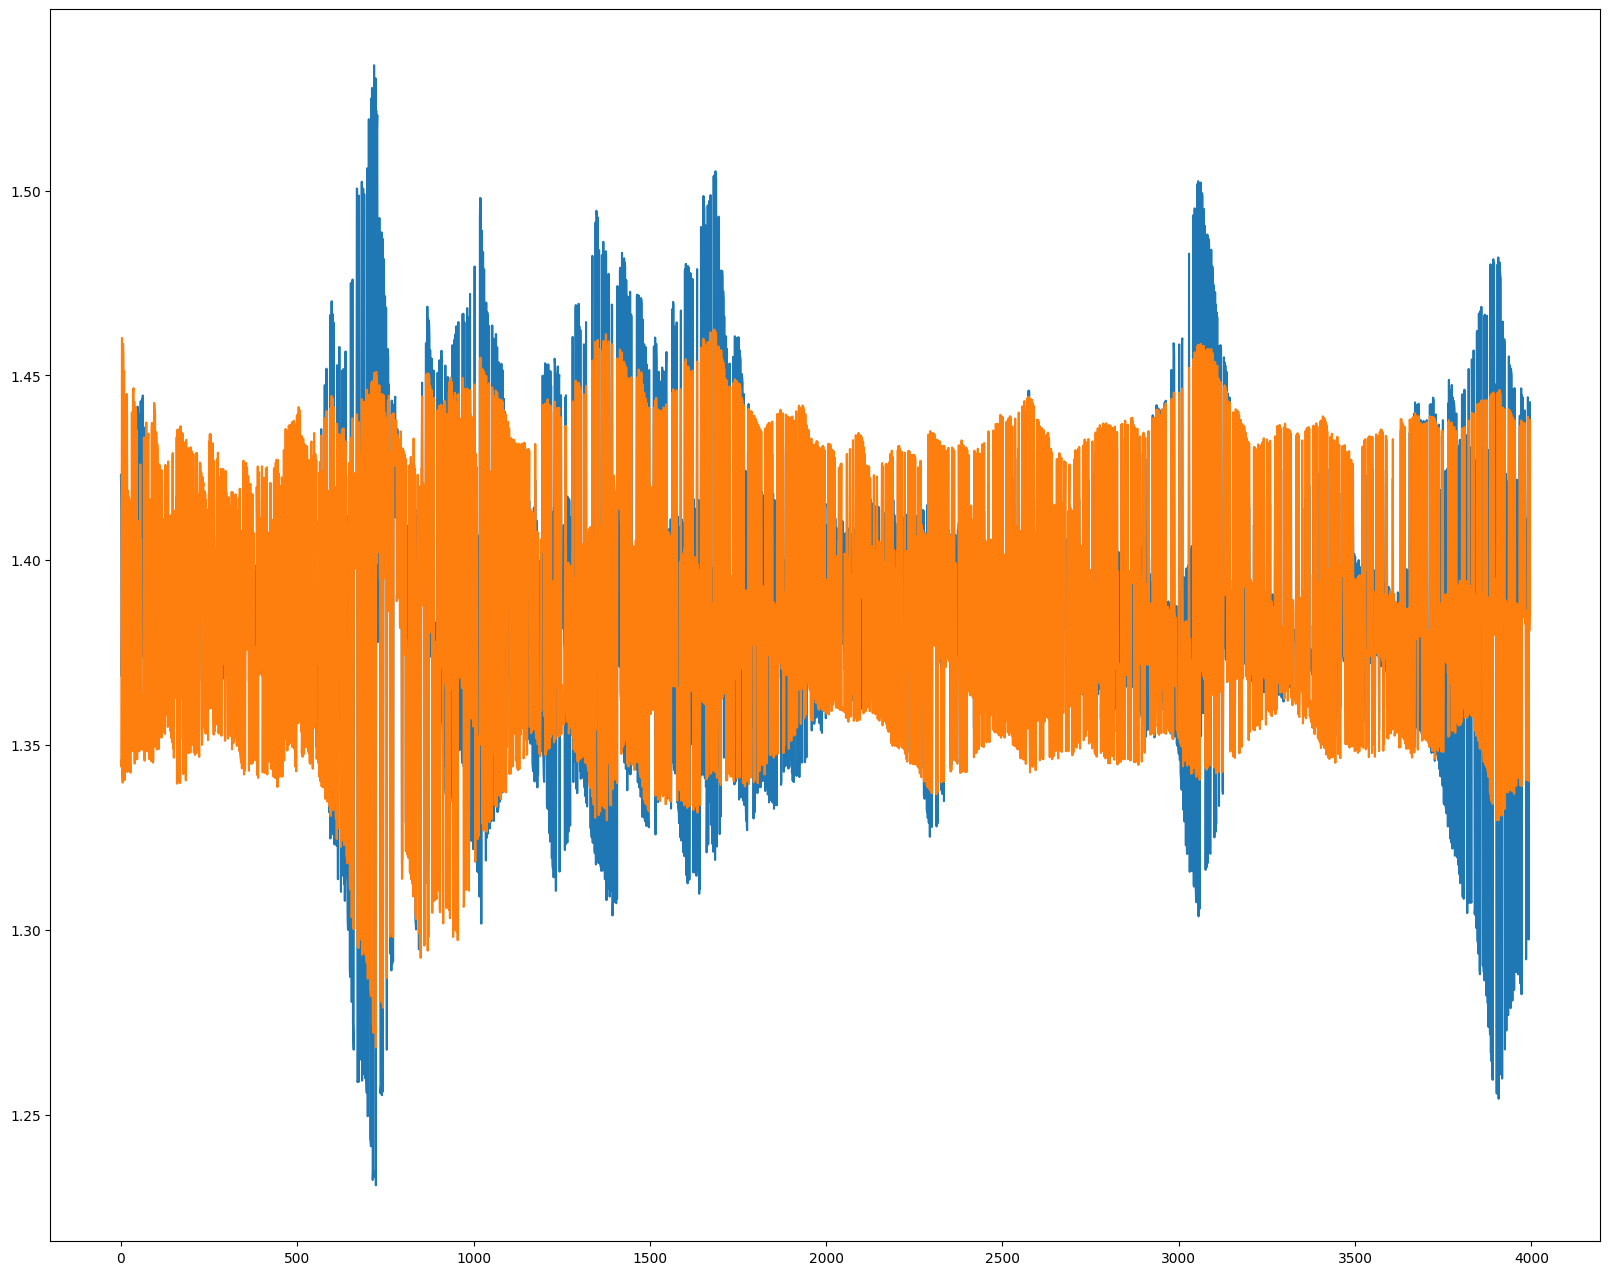

In [50]:
plt.figure(figsize=(20, 16))
plt.plot(pred_loss_list_, label="pred")
plt.plot(reg_loss_list_, label='reg')

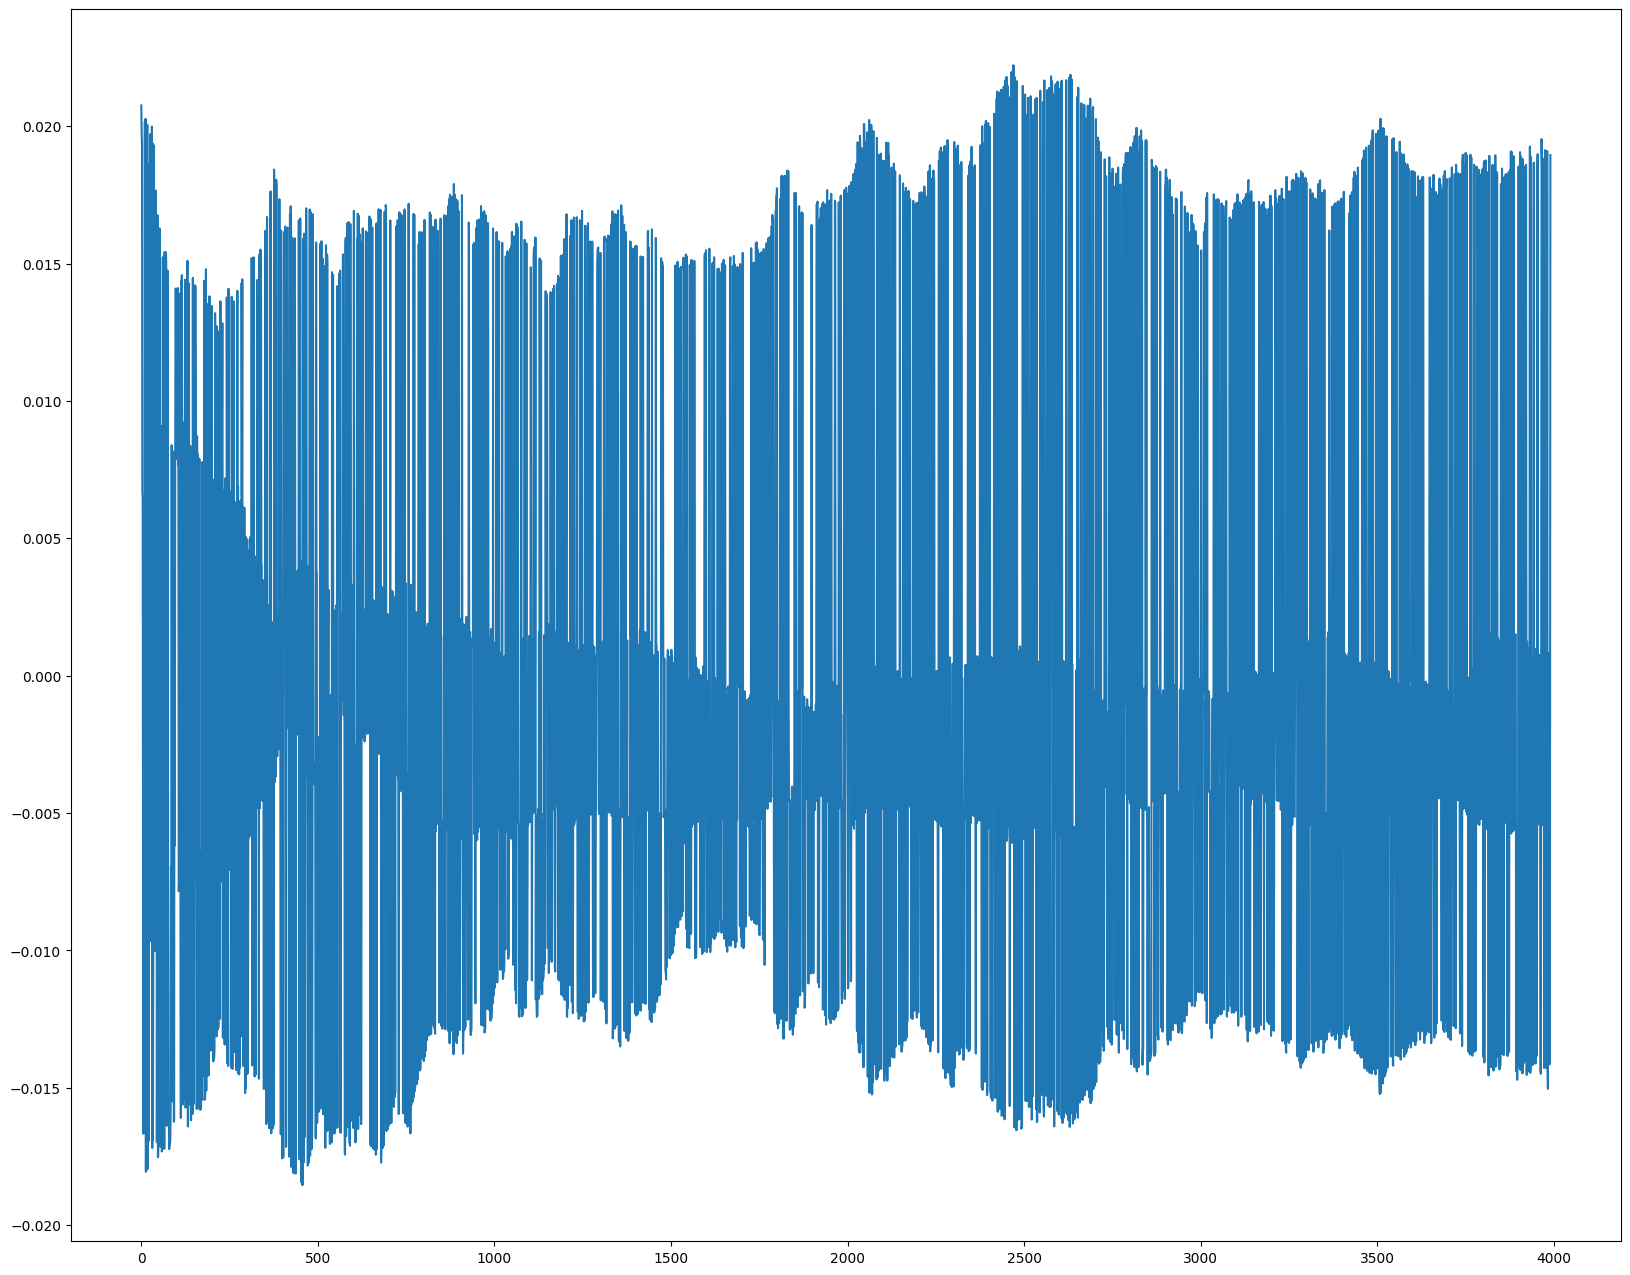

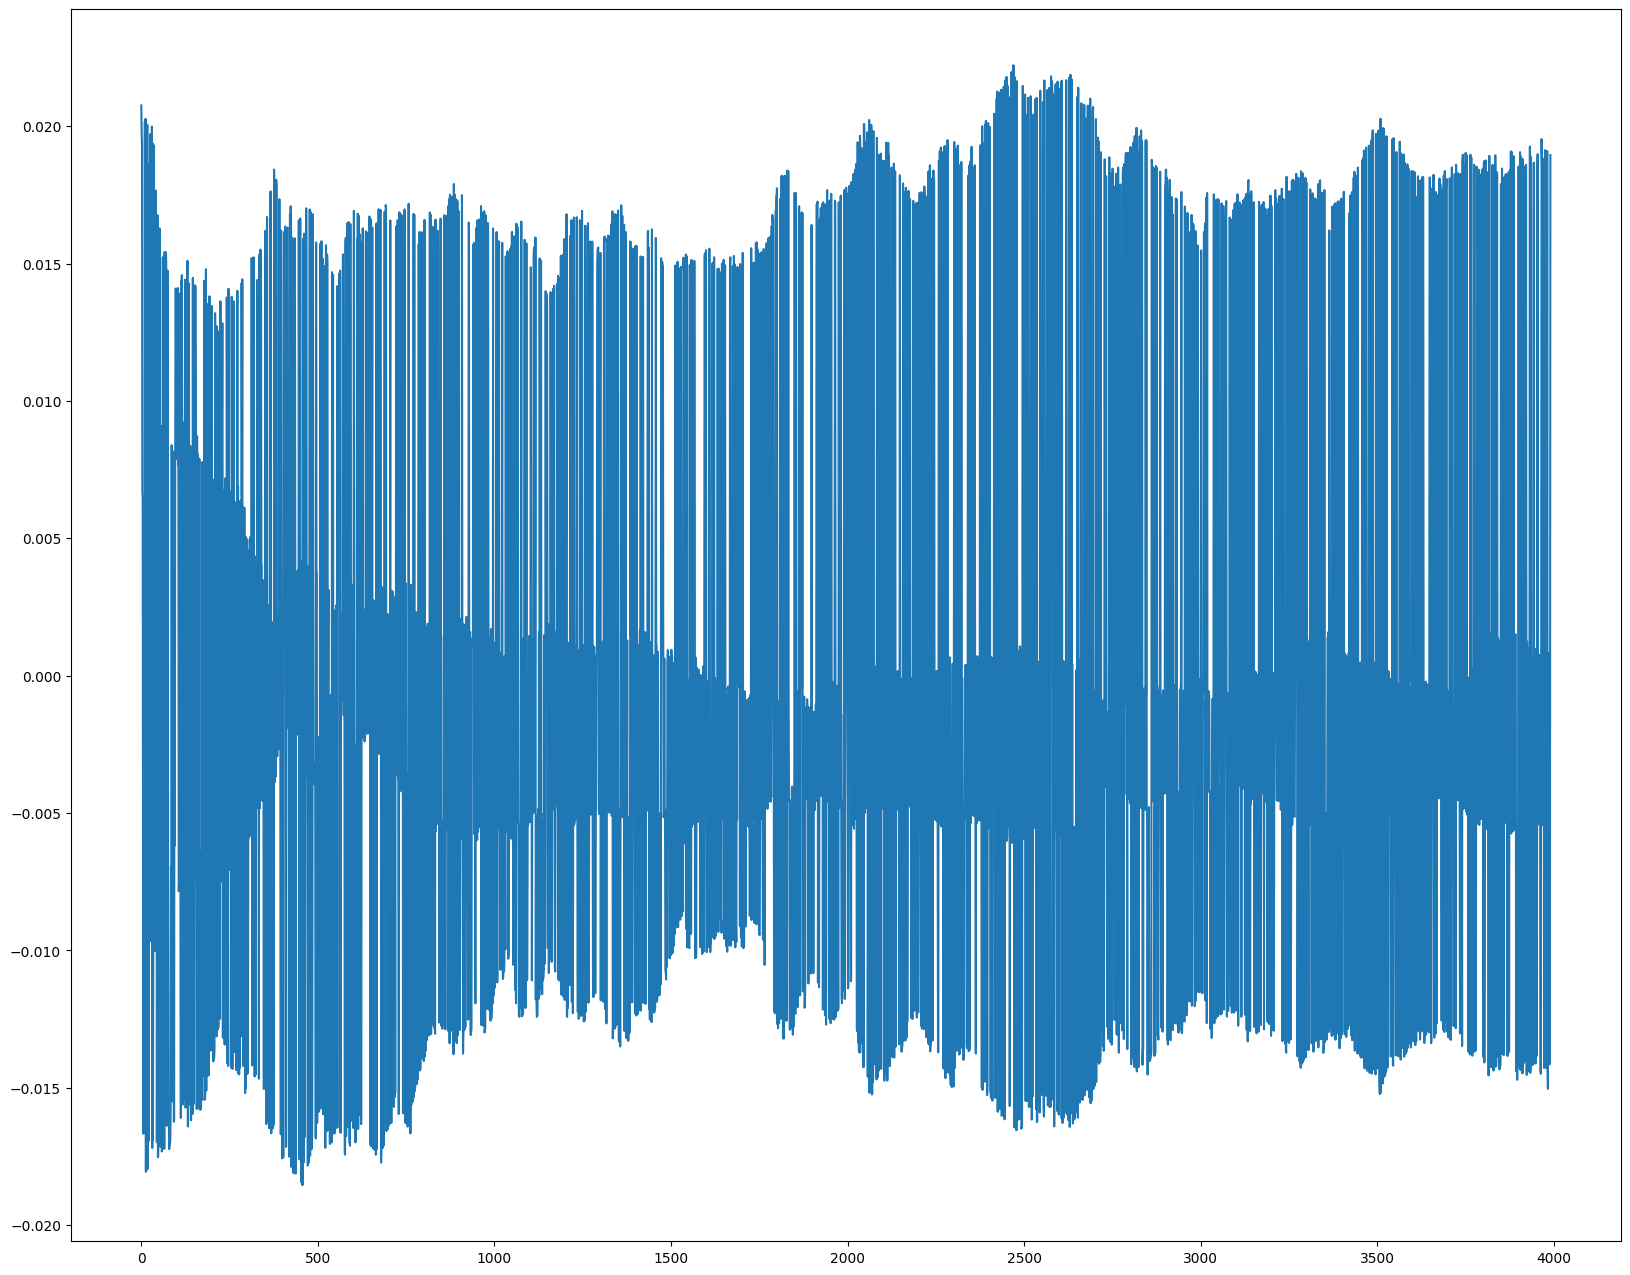

In [75]:
plt.figure(figsize=(20, 16))
plt.plot(reward_list_)

In [30]:
env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.FullFrame(env)
env = gym.wrappers.RecordVideo(env, video_folder="eval", name_prefix="eval",
                               episode_trigger=lambda x: True)
num_eval_episodes = 1

for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()

    for t in range(100):

        obs = feature_extractor(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
            0).permute((0, 3, 1, 2)))
        action = target_net(obs, torch.tensor(
            [[2]], device=device)).max(1).indices.view(1, 1)
        obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated | truncated

        if done:
            break

env.close()

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4.
Moviepy - Writing video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4


In [9]:
# torch.save(predictor_net.state_dict(), 'predict_net.dict')
# torch.save(target_net.state_dict(), 'target_net.dict')
# torch.save(policy_net.state_dict(), 'policy_net.dict')
# torch.save(regularizer_net.state_dict(), 'regularizer_net.dict')

# predictor_net.load_state_dict(torch.load('predict_net.dict'))
# target_net.load_state_dict(torch.load('target_net.dict'))
# policy_net.load_state_dict(torch.load('policy_net.dict'))
# regularizer_net.load_state_dict(torch.load('regularizer_net.dict'))

<All keys matched successfully>

In [51]:
frames = []
# env.render()

for episode in range(1):
    obs, _ = env.reset()

    for t in range(100):
        # env.render()

        frames.append(np.moveaxis(env.get_frame(), 2, 0))
        obs = feature_extractor(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)))
        action = target_net(obs, torch.tensor(
            [[1]], device=device)).max(1).indices.view(1, 1)
        obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated | truncated

        if done:
            break

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


In [52]:
# print("saving gif")
write_gif(np.array(frames), "test0.gif", fps=5)